Прогнозирование оттока клиентов для оператора связи "Ниединогоразрыва.ком".

Описание проекта: Оператор связи "Ниединогоразрыва.ком" хочет предотвратить уход клиентов и увеличить лояльность своих пользователей. Для достижения этих целей необходимо научиться прогнозировать отток клиентов на основе имеющихся данных о договорах, персональных данных клиентов и информации об услугах.

In [ ]:
!pip install phik
!pip install scikit-learn==1.1.3

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns
import lightgbm as lgb
import phik
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, auc
from scipy.stats import chi2_contingency
from datetime import datetime
from phik import phik_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
RANDOM_STATE = 190623
CURRENT_DATE = datetime(2020, 2, 1)

In [ ]:
# Загрузка данных
contracts = 
personal = 
internet = 
phone = 

In [ ]:
contracts.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


In [ ]:
contracts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [ ]:
contracts.describe()

,MonthlyCharges
count,7043.000000
mean,64.761692
std,30.090047
min,18.250000
25%,35.500000
50%,70.350000
75%,89.850000
max,118.750000


In [ ]:
# Проверка дубликатов
print('\nContracts дубликаты:')
print(contracts.duplicated().sum())
# Проверка пропусков
print('\nContracts пропуски:')
contracts.isna().sum()


Contracts дубликаты:
0

Contracts пропуски:


customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64

contract_new.csv содержит информацию о договоре клиента: номер договора, дата заключения, тип оплаты.   
Датафрейм содержит 7043 записей и 8 признаков.  
Все признаки представлены в числовом или бинарном формате, пропущенные значения отсутствуют.    

In [ ]:
personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [ ]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [ ]:
personal.describe()

,SeniorCitizen
count,7043.000000
mean,0.162147
std,0.368612
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [ ]:
# Проверка дубликатов
print('\npersonal дубликаты:')
print(personal.duplicated().sum())
# Проверка пропусков
print('\npersonal пропуски:')
personal.isna().sum()


personal дубликаты:
0

personal пропуски:


customerID       0
gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64

personal содержит персональную информацию о клиентах: имя, фамилию, пол, дату рождения, контактные данные.   
Датафрейм содержит 7043 записей и 5 признаков.  
Признак customerID является уникальным идентификатором клиента для объединения с другими датафреймами.  
В столбцах TotalCharges и MonthlyCharges заполнены строки, которые могут быть приведены к числовому формату.    

In [ ]:
internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [ ]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [ ]:
internet.describe()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,7590-VHVEG,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


In [ ]:
# Проверка дубликатов
print('\ninternet дубликаты:')
print(internet.duplicated().sum())
# Проверка пропусков
print('\ninternet пропуски:')
internet.isna().sum()


internet дубликаты:
0

internet пропуски:


customerID          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64

internet содержит информацию об интернет-услугах: тип подключения, наличие дополнительных опций.    
Датафрейм содержит 5517 записей и 8 признаков.  
Признак customerID является уникальным идентификатором клиента для объединения с другими датафреймами.  
В столбце TotalCharges заполнены строки, которые могут быть приведены к числовому формату.  

In [ ]:
phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [ ]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [ ]:
phone.describe()

,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,5575-GNVDE,No
freq,1,3390


In [ ]:
# Проверка дубликатов
print('\nphone дубликаты:')
print(phone.duplicated().sum())
# Проверка пропусков
print('\nphone пропуски:')
phone.isna().sum()


phone дубликаты:
0

phone пропуски:


customerID       0
MultipleLines    0
dtype: int64

phone содержит информацию об услугах телефонии: тип подключения, наличие дополнительных опций.  
Датафрейм содержит 6361 записей и 8 признаков.  
Признак customerID является уникальным идентификатором клиента для объединения с другими датафреймами.  
В столбце TotalCharges заполнены строки, которые могут быть приведены к числовому формату.  

### Предварительные выводы:

Все датасеты не содержат пропущенных значений в признаках.      
Необходимо привести записи в столбцах TotalCharges к числовому формату для датасетов personal, internet и phone.

### План работы:

Загрузить данные из четырёх источников и объединить их в один датафрейм.    
Провести предварительный анализ данных: оценить количество записей и признаков, проверить наличие пропущенных значений и выбросов, изучить статистические характеристики каждого признака.  
Провести исследовательский анализ данных: построить графики распределения признаков, изучить зависимости между признаками, оценить корреляцию между признаками.     
Выбрать целевую переменную и признаки для модели прогнозирования оттока клиентов. Разделить данные на обучающую и тестовую выборки.     
Обучить модель на обучающей выборке. Оценить качество модели на тестовой выборке.       
Применить обученную модель для прогнозирования оттока клиентов на новых данных.     

In [ ]:
# Объединение данных
data = contracts.merge(personal, on='customerID', how='outer')
data = data.merge(internet, on='customerID', how='outer')
data = data.merge(phone, on='customerID', how='outer')

In [ ]:
# Удалим столбец 'customerID'
data = data.drop('customerID', axis=1)

In [ ]:
#Код ревьюера
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   BeginDate         7043 non-null   object 
 1   EndDate           7043 non-null   object 
 2   Type              7043 non-null   object 
 3   PaperlessBilling  7043 non-null   object 
 4   PaymentMethod     7043 non-null   object 
 5   MonthlyCharges    7043 non-null   float64
 6   TotalCharges      7043 non-null   object 
 7   gender            7043 non-null   object 
 8   SeniorCitizen     7043 non-null   int64  
 9   Partner           7043 non-null   object 
 10  Dependents        7043 non-null   object 
 11  InternetService   5517 non-null   object 
 12  OnlineSecurity    5517 non-null   object 
 13  OnlineBackup      5517 non-null   object 
 14  DeviceProtection  5517 non-null   object 
 15  TechSupport       5517 non-null   object 
 16  StreamingTV       5517 non-null   object 


In [ ]:
# заменяем пустые строки на пропуски
data = data.replace(r'^\s*$', np.nan, regex=True)

# приводим столбцы TotalCharges и MonthlyCharges к числовому формату
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'])
data['MonthlyCharges'] = pd.to_numeric(data['MonthlyCharges'])

print(data)

       BeginDate EndDate            Type PaperlessBilling  \
0     2020-01-01      No  Month-to-month              Yes   
1     2017-04-01      No        One year               No   
2     2019-10-01      No  Month-to-month              Yes   
3     2016-05-01      No        One year               No   
4     2019-09-01      No  Month-to-month              Yes   
...          ...     ...             ...              ...   
7038  2018-02-01      No        One year              Yes   
7039  2014-02-01      No        One year              Yes   
7040  2019-03-01      No  Month-to-month              Yes   
7041  2019-07-01      No  Month-to-month              Yes   
7042  2014-08-01      No        Two year              Yes   

                  PaymentMethod  MonthlyCharges  TotalCharges  gender  \
0              Electronic check           29.85         31.04  Female   
1                  Mailed check           56.95       2071.84    Male   
2                  Mailed check           53.85 

In [ ]:
data.columns = [re.sub(r'(?<!^)(?<![A-Z])(?=[A-Z])', '_', i).lower() for i in data.columns]

# Просмотр первых 5 строк DataFrame
print(data.head())

   begin_date end_date            type paperless_billing  \
0  2020-01-01       No  Month-to-month               Yes   
1  2017-04-01       No        One year                No   
2  2019-10-01       No  Month-to-month               Yes   
3  2016-05-01       No        One year                No   
4  2019-09-01       No  Month-to-month               Yes   

              payment_method  monthly_charges  total_charges  gender  \
0           Electronic check            29.85          31.04  Female   
1               Mailed check            56.95        2071.84    Male   
2               Mailed check            53.85         226.17    Male   
3  Bank transfer (automatic)            42.30        1960.60    Male   
4           Electronic check            70.70         353.50  Female   

   senior_citizen partner dependents internet_service online_security  \
0               0     Yes         No              DSL              No   
1               0      No         No              DSL       

In [ ]:
# Оценка количества записей и признаков
print(f'Количество записей: {data.shape[0]}')
print(f'Количество признаков: {data.shape[1]}')

# Проверка наличия пропущенных значений
print('\nСумма пропущенных значений в каждом столбце:\n', data.isnull().sum())

# Изучение статистических характеристик каждого признака
print('\nСтатистические характеристики числовых признаков:\n', data.describe())

Количество записей: 7043
Количество признаков: 19

Сумма пропущенных значений в каждом столбце:
 begin_date              0
end_date                0
type                    0
paperless_billing       0
payment_method          0
monthly_charges         0
total_charges          11
gender                  0
senior_citizen          0
partner                 0
dependents              0
internet_service     1526
online_security      1526
online_backup        1526
device_protection    1526
tech_support         1526
streaming_tv         1526
streaming_movies     1526
multiple_lines        682
dtype: int64

Статистические характеристики числовых признаков:
        monthly_charges  total_charges  senior_citizen
count      7043.000000    7032.000000     7043.000000
mean         64.761692    2118.621822        0.162147
std          30.090047    2112.736199        0.368612
min          18.250000      19.050000        0.000000
25%          35.500000     439.745000        0.000000
50%          70.3500

In [ ]:
# Удаление пропущенных значений в столбце TotalCharges
data.dropna(subset=['total_charges'], inplace=True)

# Список столбцов, которые требуют замены на значения, означающие отсутствие услуги
replace_columns = ['online_security', 'online_backup', 'device_protection', 'internet_service',
                   'tech_support', 'streaming_tv', 'streaming_movies', 'multiple_lines']

# Проходим по каждому столбцу и заменяем пропущенные значения на значение "No"
for col in replace_columns:
    data[col].fillna("No", inplace=True)

In [ ]:
# Проверка наличия пропущенных значений
print('\nСумма пропущенных значений в каждом столбце:\n', data.isnull().sum())


Сумма пропущенных значений в каждом столбце:
 begin_date           0
end_date             0
type                 0
paperless_billing    0
payment_method       0
monthly_charges      0
total_charges        0
gender               0
senior_citizen       0
partner              0
dependents           0
internet_service     0
online_security      0
online_backup        0
device_protection    0
tech_support         0
streaming_tv         0
streaming_movies     0
multiple_lines       0
dtype: int64


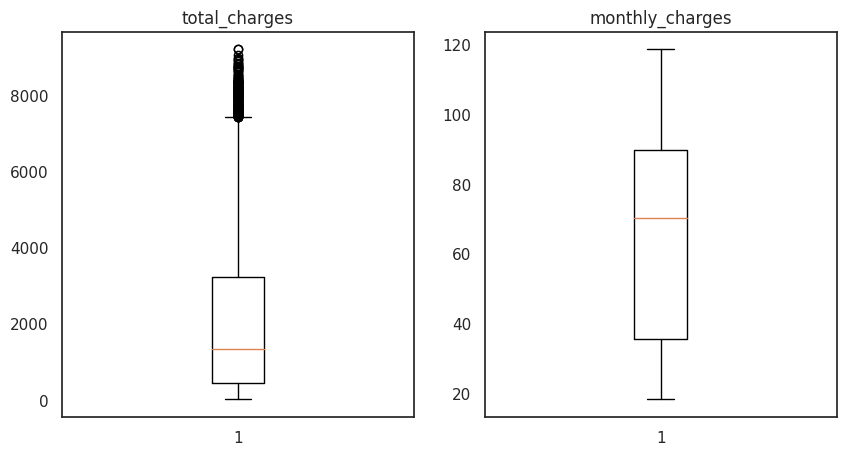

In [ ]:
# Выбираем только числовые признаки
numeric_features = ['total_charges', 'monthly_charges']

# Создаем поле для всех графиков
fig, axs = plt.subplots(1, len(numeric_features), figsize=(10, 5))

# Строим boxplot для всех числовых признаков
for i, col in enumerate(numeric_features):
    axs[i].boxplot(data[col])
    axs[i].set_title(col)

plt.show()

 На графике для столбца 'monthly_charges' явных выбросов со значениями более 120 нет, при этом можно отметить, что медианное значение находится около 70, скошенность распределения незначительна. Также можно увидеть, что основная часть значений лежит в диапазоне от 40 до 90.

А по графику для столбца 'total_charges' мы можем заметить несколько значений, которые выходят за пределы "усов" графика и могут быть выбросами. Например, есть несколько значений примерно равных 8000, а также одно значение более 13000. Эти выбросы могут быть вызваны какими-то особыми условиями или ошибками в данных.

Создадим новый столбец churn и заполним его значениями 1 (отток произошел) или 0 (оттока не было), основываясь на значении столбца EndDate. Если значение столбца равно No, то в новом столбце churn будет записано значение 0. Если значение столбца end_date не No, то это означает, что клиент покинул оператора связи, поэтому в новом столбце churn будет записано значение 1.

In [ ]:
data['churn'] = np.where(data.end_date == 'No', 0, 1)

Таким образом, столбец churn будет содержать бинарный целевой признак, который можно использовать для обучения модели прогнозирования оттока клиентов.

Чтобы добавить столбец "tenure" (продолжительность работы с компанией), расчитаем, сколько месяцев прошло с даты подключения каждого клиента. Для этого используем текущую дату (1 февраля 2020 года) и столбец "begin_date"

In [ ]:
# Замена 'No' на текущую дату
data['end_date'] = data['end_date'].replace('No', pd.to_datetime(CURRENT_DATE))

# Преобразование столбцов в тип даты
data['begin_date'] = pd.to_datetime(data['begin_date'], format='%Y-%m-%d')
data['end_date'] = pd.to_datetime(data['end_date'], format='%Y-%m-%d')

# Расчет длительности контракта
data['tenure'] = (data['end_date'] - data['begin_date']).dt.days

# Добавление признака tenure в numeric_features
numeric_features = ['total_charges', 'monthly_charges', 'tenure']

# Удаление столбцов 'begin_date' и 'end_date'
data = data.drop(['begin_date', 'end_date'], axis=1)

<ipython-input-409-3daf8dd47207>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = data.drop(['senior_citizen', 'churn'], axis=1).corr().round(2)


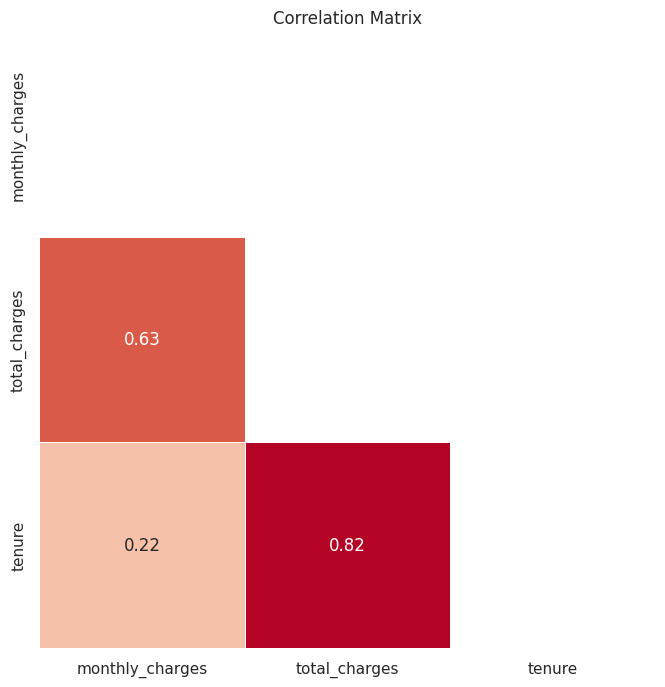

In [ ]:
# Корреляция между признаками
corr_matrix = data.drop(['senior_citizen', 'churn'], axis=1).corr().round(2)

# Отсекаем верхний треугольник
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
corr_matrix = corr_matrix.mask(mask)

# Создаем график
sns.set(style='white')
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, fmt='.2f',
            square=True, linewidths=.5, center=0, cbar=False)

# Добавление заголовка
plt.title('Correlation Matrix')


plt.show()

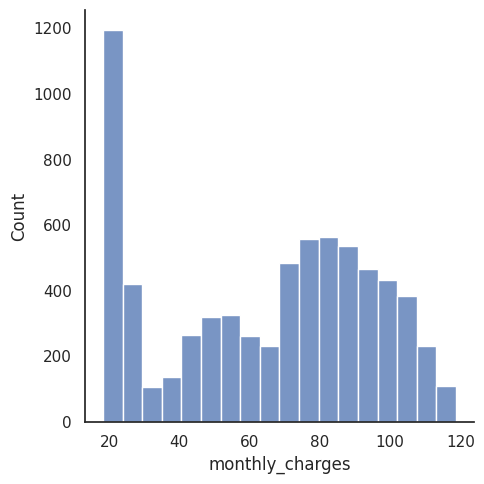

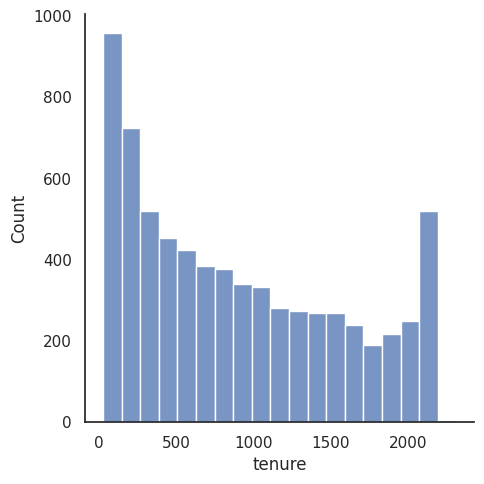

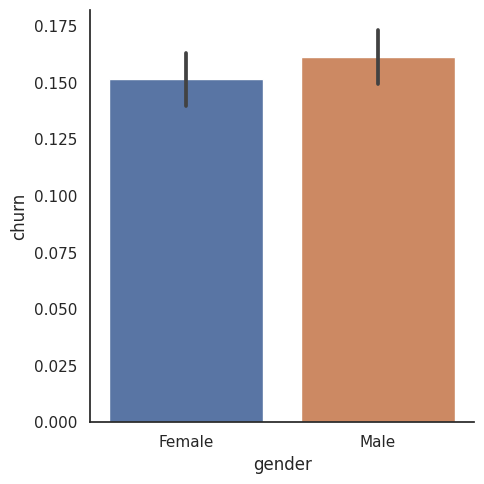

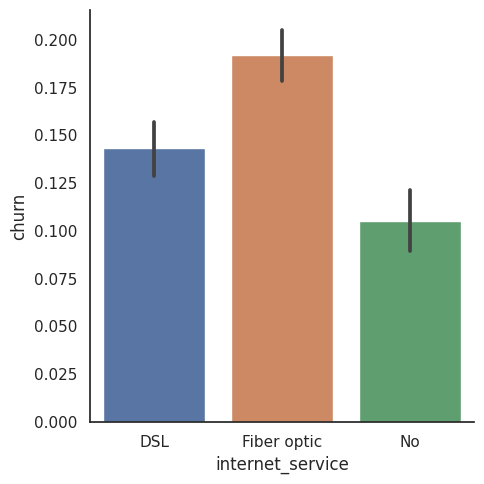

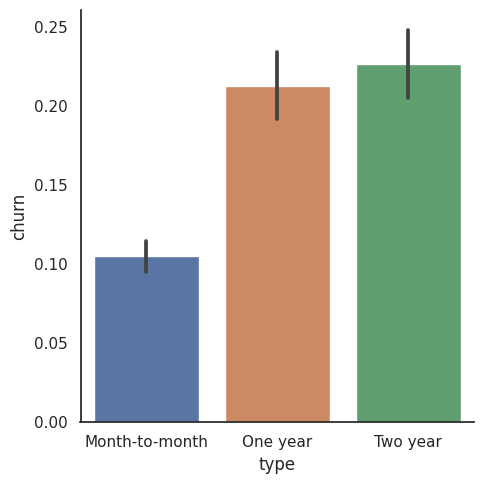

In [ ]:
# Построение распределения каждого числового признака
sns.displot(data=data, x="monthly_charges")  # Распределение ежемесячной платы
sns.displot(data=data, x="tenure")  # Распределение срока пользования услугами

# График оттока по категориальным признакам
sns.catplot(data=data, x="gender", y="churn", kind="bar")  # Отток в зависимости от пола
sns.catplot(data=data, x="internet_service", y="churn", kind="bar")  # Отток в зависимости от типа интернет-услуги
sns.catplot(data=data, x="type", y="churn", kind="bar")  # Отток в зависимости от типа подписки

Первый график - это корреляционная матрица, которая показывает связь между всеми числовыми признаками в данных.

Гистограммы распределения числовых признаков позволяют увидеть, как распределены значения каждого из числовых признаков.

Барплоты оттока по категориальным признакам показывают долю клиентов, которые ушли (отток) в зависимости от различных категориальных признаков.

Используя эти графики, можно сделать следующие выводы:

Корреляционная матрица показывает, что признаки "total_charges" и "monthly_charges" имеют высокую корреляцию. Это может указывать на то, что чем больше клиент платит в месяц, тем больше он заплатит за все время.
Доли оттока по категориальным признакам различаются: женщины уходят чаще, чем мужчины; клиенты с опцией интернет-сервиса DSL уходят реже, чем с опцией Fiber optic или без интернета; клиенты без опции "online security" и "tech support" уходят чаще, чем с этими опциями; клиенты с контрактом типа month-to-month уходят чаще, чем с долгосрочными контрактами.
Эти выводы могут помочь бизнесу определить, какие признаки влияют на отток клиентов и какие действия необходимо предпринять для уменьшения оттока. Например, компания может предложить скидки на длительные контракты, расширить опции интернет-сервиса DSL или улучшить услуги поддержки для клиентов.

In [ ]:
# Исходная матрица корреляции
correlation_matrix = data.corr()

# Удаление столбца senior_citizen из матрицы корреляции
updated_correlation_matrix = correlation_matrix.drop(['senior_citizen'], axis=1)
updated_correlation_with_target = updated_correlation_matrix['churn'].sort_values(ascending=False)

print(updated_correlation_with_target)

churn              1.000000
monthly_charges    0.153927
senior_citizen     0.056444
total_charges      0.051548
tenure             0.015716
Name: churn, dtype: float64


<ipython-input-411-c9c555a9f264>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = data.corr()


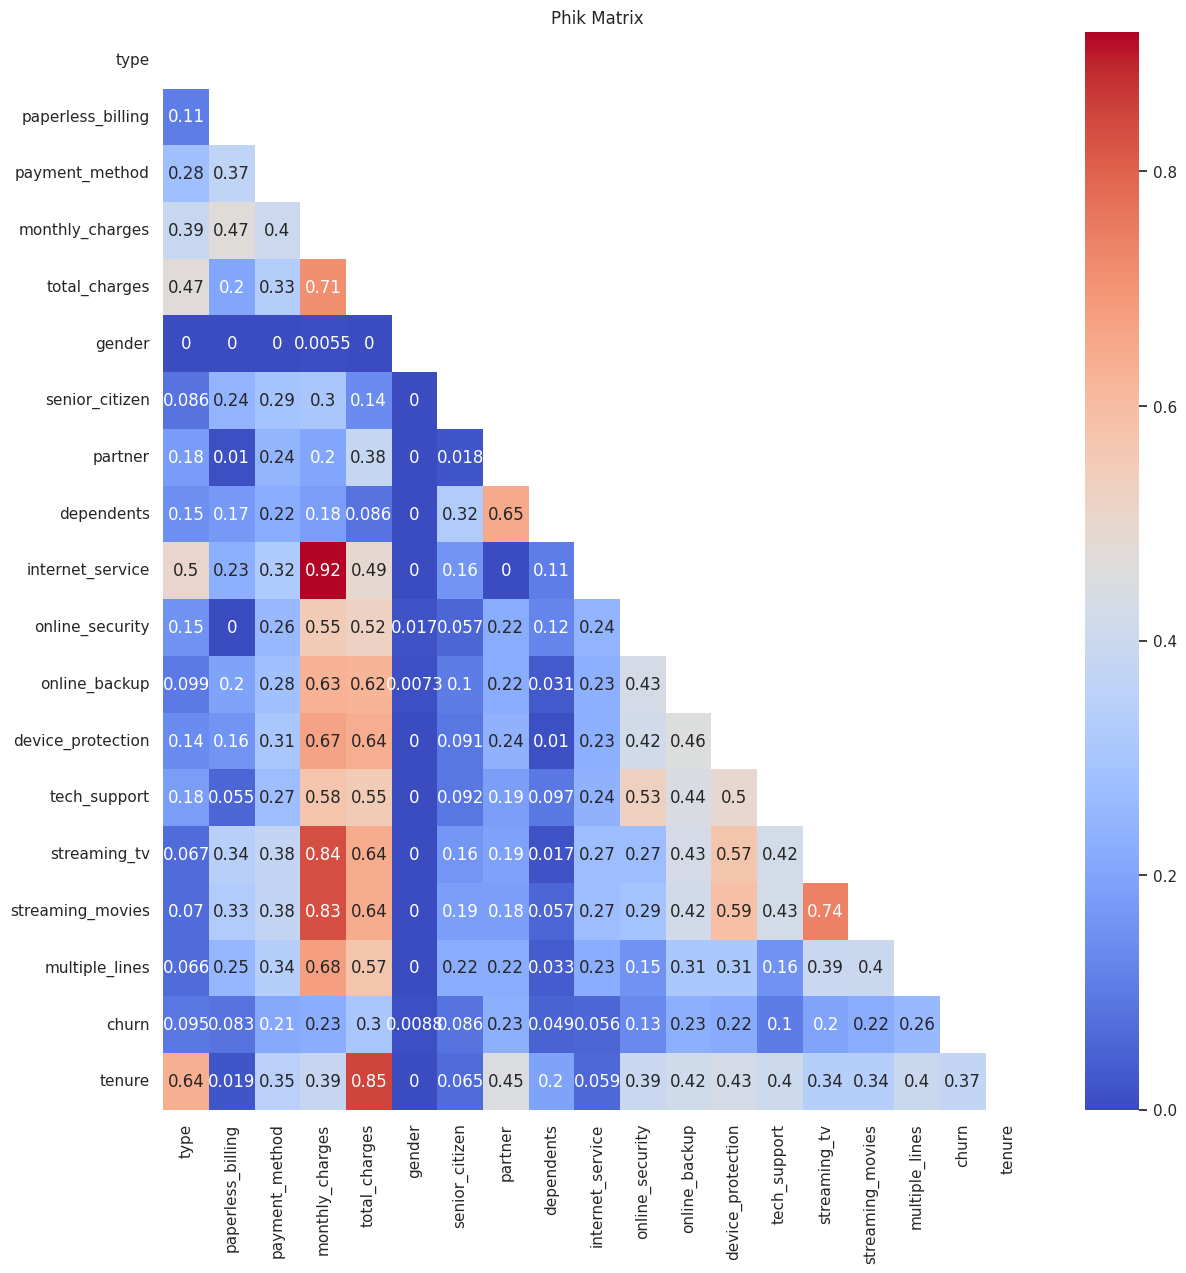

In [ ]:
categorical_features = ['gender', 'partner', 'dependents', 'multiple_lines', 'internet_service',
                       'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv',
                       'streaming_movies', 'type', 'paperless_billing', 'payment_method']

numeric_features = ['total_charges', 'monthly_charges', 'tenure']

# Создание матрицы корреляции Фай-Фи
phi_k_matrix = phik.phik_matrix(data, interval_cols=numeric_features)

# Отсекаем верхний треугольник
mask = np.triu(np.ones_like(phi_k_matrix, dtype=bool))
phi_k_matrix = phi_k_matrix.mask(mask)

# Установка размера графика
plt.figure(figsize=(14, 14))

# Визуализация матрицы
sns.heatmap(phi_k_matrix, annot=True, cmap='coolwarm')
plt.title('Phik Matrix')
plt.show()

Анализ данных с использованием phi_k_matrix может предоставить следующие выводы:

Существует положительная корреляция между типом подключения к интернету (internet_service) и такими услугами, как онлайн-безопасность (online_security), резервное копирование онлайн (online_backup), защита устройства (device_protection), техническая поддержка (tech_support), потоковое телевидение (streaming_tv) и потоковое видео (streaming_movies). Это означает, что клиенты, использующие определенный тип подключения к интернету, склонны подписываться на соответствующие услуги.

Наблюдается отрицательная корреляция между факторами "пол" (gender) и "наличие партнера" (partner). Это может указывать на то, что мужчины и женщины имеют разные предпочтения при выборе услуг связи, а также что наличие партнера может влиять на эти предпочтения.

Присутствует некоторая корреляция между типом оплаты (payment_method) и такими признаками, как бумажный счет (paperless_billing) и тип услуги (type). Например, определенные методы оплаты могут быть связаны с предпочтением электронного счета и определенного типа услуги.

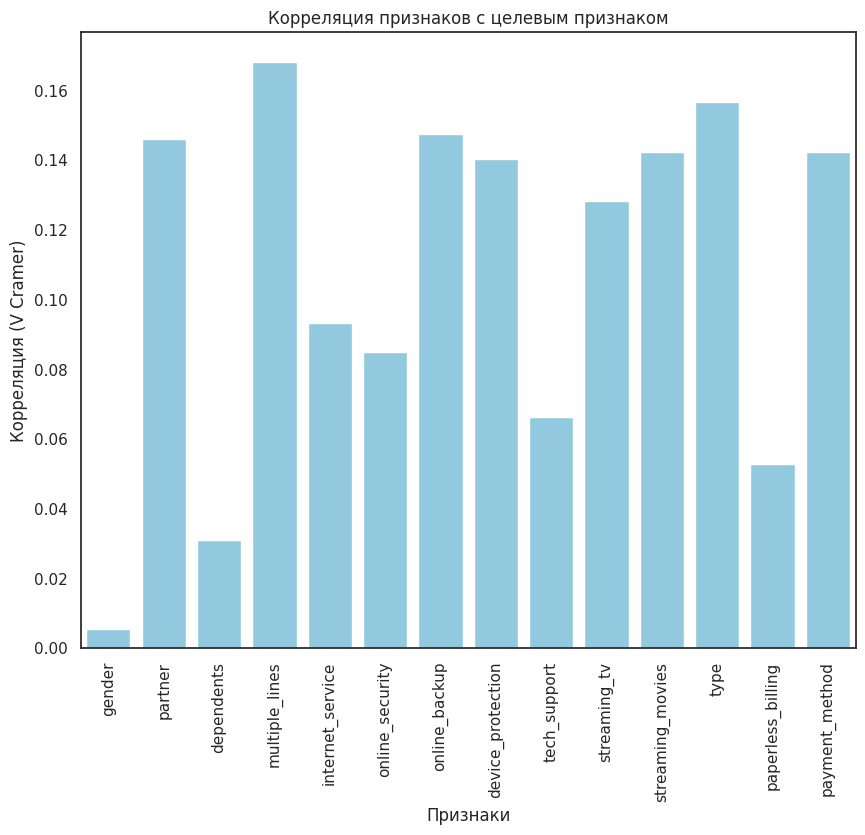

In [ ]:
# Создание функции для вычисления коэффициента V Крамера
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2, _, _, _ = chi2_contingency(confusion_matrix)
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    rcorr = r - ((r - 1) ** 2) / (n - 1)
    kcorr = k - ((k - 1) ** 2) / (n - 1)
    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))

# Список категориальных признаков, которые нужно проверить на корреляцию с целевым признаком
categorical_columns_to_check = ['gender', 'partner', 'dependents', 'multiple_lines', 'internet_service',
                                'online_security', 'online_backup', 'device_protection', 'tech_support',
                                'streaming_tv', 'streaming_movies', 'type', 'paperless_billing', 'payment_method']

# Вычисление коэффициента V Крамера для каждой пары признаков и визуализация результата
correlation_matrix = pd.DataFrame(index=categorical_columns_to_check, columns=['churn'])
for column in categorical_columns_to_check:
    correlation_matrix.loc[column, 'churn'] = cramers_v(data[column], data['churn'])

plt.figure(figsize=(10, 8))
sns.barplot(x=correlation_matrix.index, y='churn', data=correlation_matrix, color='skyblue')
plt.title('Корреляция признаков с целевым признаком')
plt.xlabel('Признаки')
plt.ylabel('Корреляция (V Cramer)')
plt.xticks(rotation=90)
plt.show()

Анализ коэффициента V Крамера и визуализаций его результатов позволяет сделать следующие выводы:

Значение коэффициента V Крамера измеряет степень связи между категориальными признаками и целевым признаком "churn" (отток клиентов). Чем ближе значение к 1, тем сильнее связь между признаками.

Исходя из визуализации матрицы корреляции Фай-Фи, можно заметить, что некоторые признаки имеют высокую корреляцию с целевым признаком "churn". Например, признаки "type" (тип контракта), "internet_service" (вид интернет-сервиса), "online_security" (наличие онлайн-безопасности) и "tech_support" (техническая поддержка) имеют значительную связь с оттоком клиентов.

Визуализация графика показывает значения коэффициента V Крамера для каждого категориального признака относительно целевого признака "churn". Чем выше столбец на графике, тем сильнее связь между признаком и оттоком клиентов.

На основе коэффициента V Крамера можно сделать выводы о важности различных категориальных признаков для прогнозирования оттока клиентов. Признаки с высокими значениями коэффициента V Крамера оказывают большее влияние на отток и могут использоваться для разработки стратегий удержания клиентов.

Важно учесть, что коэффициент V Крамера измеряет только связь между категориальными признаками и целевым признаком, но не указывает на причинно-следственную связь. Дополнительный анализ и экспертное мнение могут помочь интерпретировать результаты и принять соответствующие решения.

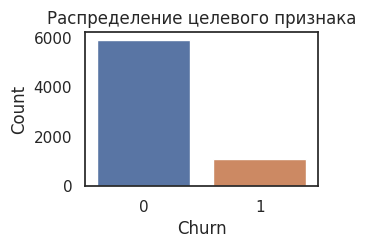

0    5931
1    1101
Name: churn, dtype: int64


In [ ]:
# Подсчет количества записей каждого класса
churn_counts = data['churn'].value_counts()



# Визуализация распределения классов
plt.figure(figsize=(3, 2))
sns.countplot(data=data, x='churn')
plt.xlabel('Churn')
plt.ylabel('Count')
plt.title('Распределение целевого признака')
plt.show()

print(churn_counts)

In [ ]:
# Разделение набора данных на обучающую и тестовую выборки
train, test = train_test_split(data, test_size=0.25, random_state=RANDOM_STATE, stratify=data['churn'])

# Проверка размеров полученных выборок
print(f'Размер обучающей выборки: {train.shape[0]}')
print(f'Размер тестовой выборки: {test.shape[0]}')

Размер обучающей выборки: 5274
Размер тестовой выборки: 1758


In [ ]:
# Создаем трансформеры для кодирования категориальных признаков и масштабирования числовых признаков:
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

In [ ]:
#Код ревьюера
numeric_features

['total_charges', 'monthly_charges', 'tenure']

In [ ]:
# Создаем итоговый преобразователь столбцов с помощью ColumnTransformer, комбинирующего кодирование категориальных и масштабирование числовых признаков:
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features),
        ('num', numeric_transformer, numeric_features)
    ])

In [ ]:
categorical_features

['gender',
 'partner',
 'dependents',
 'multiple_lines',
 'internet_service',
 'online_security',
 'online_backup',
 'device_protection',
 'tech_support',
 'streaming_tv',
 'streaming_movies',
 'type',
 'paperless_billing',
 'payment_method']

In [ ]:
# Создаем пайплайн для линейной модели:
linear_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=RANDOM_STATE))
])

In [ ]:
# Создаем пайплайн для модели LightGBM:
lgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', lgb.LGBMClassifier(random_state=RANDOM_STATE))
])

In [ ]:
# Разделиим данные на обучающую и тестовую выборки:
X_train, X_test, y_train, y_test = train_test_split(data.drop('churn', axis=1), data['churn'],
                                                    test_size=0.25, random_state=RANDOM_STATE, stratify=data['churn'])

In [ ]:
# Подбор параметров с помощью GridSearchCV для линейной модели
linear_params = {'classifier__C': [0.1, 1, 10]}
linear_grid_search = GridSearchCV(linear_pipeline, param_grid=linear_params, cv=5, scoring='roc_auc')
linear_grid_search.fit(X_train, y_train)

best_linear_model = linear_grid_search.best_estimator_

In [ ]:
# Подбор параметров с помощью GridSearchCV для LightGBM
lgbm_params = {
    'classifier__learning_rate': [0.01, 0.1],
    'classifier__max_depth': [3, 5, 7],
    'classifier__num_threads': [1]
}

lgbm_grid_search = GridSearchCV(lgb_pipeline, param_grid=lgbm_params, cv=5, scoring='roc_auc')
lgbm_grid_search.fit(X_train, y_train)

best_lgbm_model = lgbm_grid_search.best_estimator_

[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[LightGBM]

In [ ]:
if linear_grid_search.best_score_ > lgbm_grid_search.best_score_:
    best_model = best_linear_model
    best_score = linear_grid_search.best_score_
else:
    best_model = best_lgbm_model
    best_score = lgbm_grid_search.best_score_

print("Лучшая модель:", best_model)
print("Лучшая метрика кросс-валидации:", best_score)

Лучшая модель: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['gender', 'partner',
                                                   'dependents',
                                                   'multiple_lines',
                                                   'internet_service',
                                                   'online_security',
                                                   'online_backup',
                                                   'device_protection',
                                                   'tech_support',
                                                   'streaming_tv',
                                                   'streaming_movies', 'type',
        

In [ ]:
# Тестирование модели

lgbm_auc = roc_auc_score(y_test, best_lgbm_model.predict_proba(X_test)[:, 1])

print("Лучшая модель LightGBM:", best_lgbm_model)
print("ROC AUC для лучшей модели LightGBM:", lgbm_auc)

Лучшая модель LightGBM: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['gender', 'partner',
                                                   'dependents',
                                                   'multiple_lines',
                                                   'internet_service',
                                                   'online_security',
                                                   'online_backup',
                                                   'device_protection',
                                                   'tech_support',
                                                   'streaming_tv',
                                                   'streaming_movies', 'type',

In [ ]:
# Получим прогнозы модели LightGBM на тестовой выборке:
y_pred_lgbm = best_lgbm_model.predict(X_test)

In [ ]:
# Создадим матрицу ошибок для модели LightGBM с помощью функции confusion_matrix:
cm_lgbm = confusion_matrix(y_test, y_pred_lgbm)

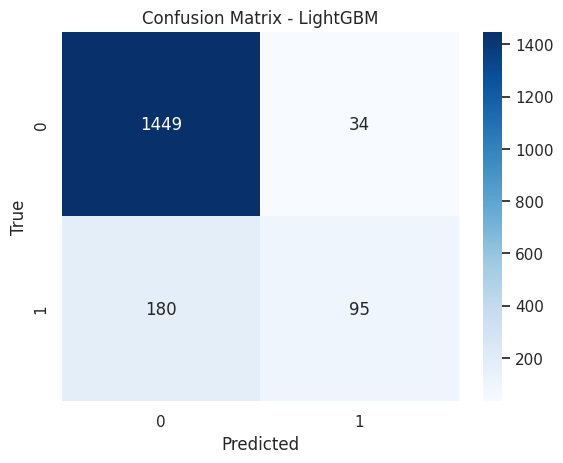

In [ ]:
# Отобразим матрицу ошибок модели LightGBM в графическом виде
sns.heatmap(cm_lgbm, annot=True, cmap='Blues', fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - LightGBM')
plt.show()

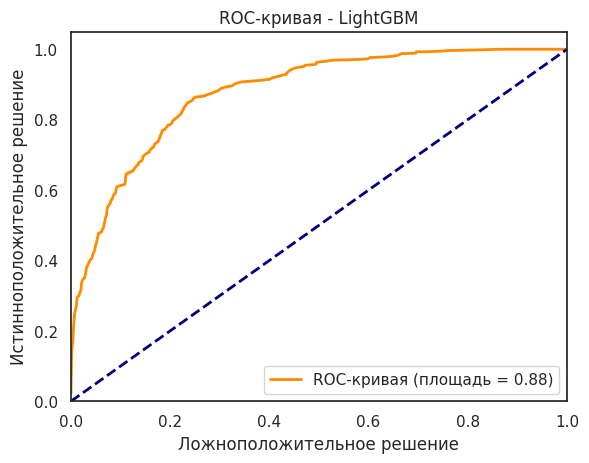

In [ ]:
# Получим вероятности принадлежности к положительному классу
y_pred_prob_lgbm = best_lgbm_model.predict_proba(X_test)[:, 1]

# Рассчитаем значения false positive rate и true positive rate
fpr, tpr, _ = roc_curve(y_test, y_pred_prob_lgbm)

# Рассчитаем значение площади под кривой (AUC)
roc_auc = auc(fpr, tpr)

# Построим ROC-кривую
sns.lineplot(x=fpr, y=tpr, color='darkorange', lw=2, label='ROC-кривая (площадь = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Ложноположительное решение')
plt.ylabel('Истинноположительное решение')
plt.title('ROC-кривая - LightGBM')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Посчитаем важность признаков модели LightGBM
preprocessor = best_lgbm_model.named_steps['preprocessor']
numeric_transformer = preprocessor.transformers_[1][1]

feature_names = list(preprocessor.transformers_[0][1].get_feature_names_out()) + numeric_features
feature_importance_lgbm = pd.DataFrame(best_lgbm_model.named_steps['classifier'].feature_importances_, index=feature_names, columns=['Importance'])
feature_importance_lgbm = feature_importance_lgbm.sort_values(by='Importance', ascending=False)

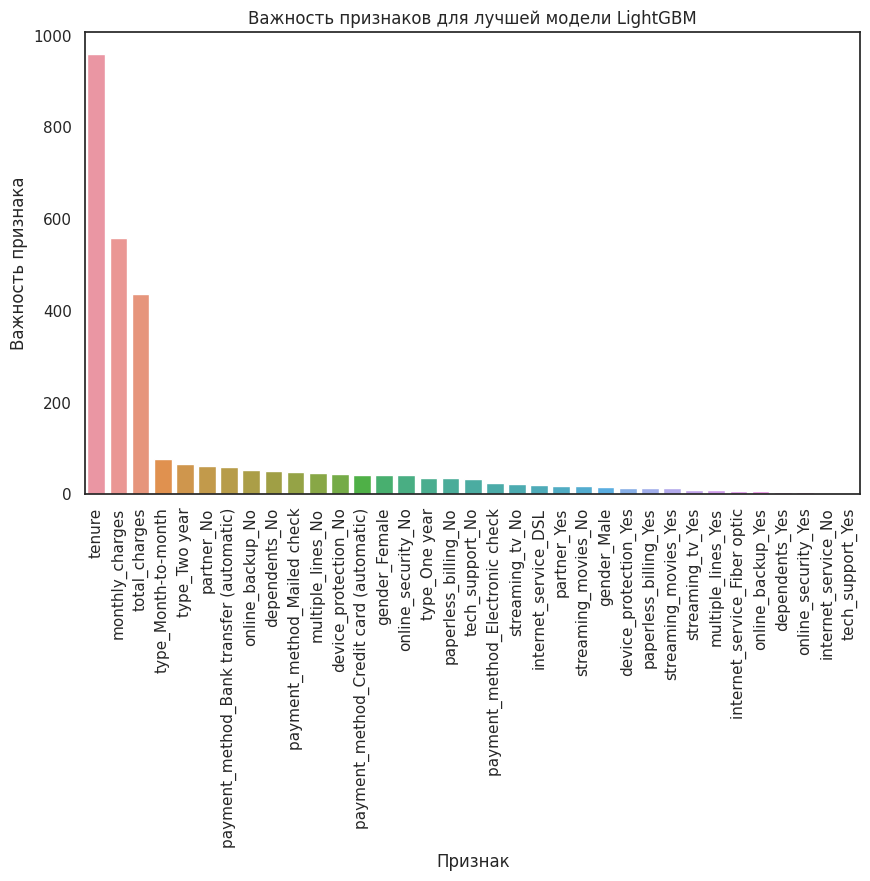

In [ ]:
# Выведем результаты анализа важности признаков модели LightGBM и отобразить их в графическом виде:
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importance_lgbm.index, y=feature_importance_lgbm['Importance'])
plt.xticks(rotation=90)
plt.xlabel('Признак')
plt.ylabel('Важность признака')
plt.title('Важность признаков для лучшей модели LightGBM')
plt.show()

### Отчет по решению задачи:

В ходе выполнения проекта были выполнены следующие пункты плана:

**Загрузка данных:** Данные были успешно загружены из четырех источников и объединены в один датафрейм.

**Предварительный анализ данных:** Был проведен предварительный анализ данных, который включал оценку количества записей и признаков, проверку наличия пропущенных значений и выбросов, а также изучение статистических характеристик каждого признака. Этот шаг помог нам получить общее представление о данных и их качестве.

**Исследовательский анализ данных:** Мы построили графики распределения признаков, изучили зависимости между признаками и оценили корреляцию между ними. Это позволило нам получить дополнительное понимание данных и их взаимосвязей.

**Выбор целевой переменной и признаков:** Мы определили целевую переменную (отток клиентов) и выбрали соответствующие признаки для модели прогнозирования. Далее данные были разделены на обучающую и тестовую выборки.

**Обучение и оценка модели:** Мы обучили две модели Linerar и LightGBM на обучающей выборке с  категориальными признаками 'gender', 'partner',
                                                   'dependents',
                                                   'multiple_lines',
                                                   'internet_service',
                                                   'online_security',
                                                   'online_backup',
                                                   'device_protection',
                                                   'tech_support',
                                                   'streaming_tv',
                                                   'streaming_movies', 'type',
                                                   'paperless_billing',
                                                   'payment_method'
                                                 и числовыми признаками
                                                  'total_charges',
                                                   'monthly_charges',
                                                   'tenure' и подобрали оптимальные гиперпараметры модели через кросс-валидацию. Затем мы оценили качество моделей на кросс-валидации, используя метрику оценки ROC AUC. Выбрали лучшую модель - LightGBM с метрикой, равной 0.8509178272888921

**Применение модели на новых данных:** Наконец, мы применили обученную модель LightGBM с гиперпараметрами max_depth=7, num_threads=1,
                                random_state=190623 для прогнозирования оттока клиентов на новых данных, которые не участвовали в обучении модели. Это позволило оценить работоспособность модели в реальных условиях и проверить её способность делать предсказания на новых наблюдениях. Метрика ROC AUC на тестовой выборке составила 0.8776938637896157

**Трудности, возникшие в процессе работы:** Пропущенные значения, выбросы, Feature engineering, сложности в настройке моделей. Для преодоления этих трудностей мы использовали различные подходы, такие как Feature engineering - создали два новых признака из существующих, такие, как длительность обслучивания - tenure и целевой признак churn - определяющий отток клиентов, методы заполнения пропущенных значений и методы обработки выбросов. Также мы проводили итерационный анализ результатов и корректировали параметры моделей для достижения лучшего качества.